# import libreries

In [1]:
import requests
import pandas as pd
import nltk
import re
import numpy as np
from nltk.tokenize import sent_tokenize
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Model
from keras.preprocessing.sequence import skipgrams
from keras.preprocessing import text
from keras.layers import dot
from keras.layers.core import Dense, Reshape, Embedding
from keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

  # preprocessing

In [3]:
url = 'https://ocw.mit.edu/ans7870/6/6.006/s08/lecturenotes/files/t8.shakespeare.txt'
r = requests.get(url, allow_redirects=True)

open('shakespeare.txt', 'wb').write(r.content)

5458199

In [4]:
with open('shakespeare.txt', 'r') as f:
    book = f.read()

In [5]:
sentences = sent_tokenize(book)

In [6]:
data = pd.DataFrame({'raw_text':sentences})
data

,raw_text
0,This is the 100th Etext file presented by Proj...
1,Project Gutenberg\noften releases Etexts that ...
2,Shakespeare\n\n*This Etext has certain copyrig...
3,*\n\n<<THIS ELECTRONIC VERSION OF THE COMPLETE...
4,ELECTRONIC AND MACHINE READABLE COPIES MAY BE\...
...,...
96044,"Ay me, I fell, and yet do question make\n Wha..."
96045,"'O, that infected moisture of his eye,\n O, t..."
96046,THE END\n\n\n\n<<THIS ELECTRONIC VERSION OF TH...
96047,ELECTRONIC AND MACHINE READABLE COPIES MAY BE\...


In [7]:
#library that contains punctuation
import string
string.punctuation

#defining the function to remove punctuation
def remove_punctuation(text):
    text = re.sub('\n', ' ', text)
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    return punctuationfree

#storing the puntuation free text
data["remove_punct"]= data["raw_text"].apply(lambda x:remove_punctuation(x))

In [8]:
data

,raw_text,remove_punct
0,This is the 100th Etext file presented by Proj...,This is the 100th Etext file presented by Proj...
1,Project Gutenberg\noften releases Etexts that ...,Project Gutenberg often releases Etexts that a...
2,Shakespeare\n\n*This Etext has certain copyrig...,Shakespeare This Etext has certain copyright ...
3,*\n\n<<THIS ELECTRONIC VERSION OF THE COMPLETE...,THIS ELECTRONIC VERSION OF THE COMPLETE WORK...
4,ELECTRONIC AND MACHINE READABLE COPIES MAY BE\...,ELECTRONIC AND MACHINE READABLE COPIES MAY BE ...
...,...,...
96044,"Ay me, I fell, and yet do question make\n Wha...",Ay me I fell and yet do question make What I...
96045,"'O, that infected moisture of his eye,\n O, t...",O that infected moisture of his eye O that f...
96046,THE END\n\n\n\n<<THIS ELECTRONIC VERSION OF TH...,THE END THIS ELECTRONIC VERSION OF THE COMP...
96047,ELECTRONIC AND MACHINE READABLE COPIES MAY BE\...,ELECTRONIC AND MACHINE READABLE COPIES MAY BE ...


In [9]:
# lowering text
data['lowercase']= data['remove_punct'].apply(lambda x: x.lower())
data.head()

,raw_text,remove_punct,lowercase
0,This is the 100th Etext file presented by Proj...,This is the 100th Etext file presented by Proj...,this is the 100th etext file presented by proj...
1,Project Gutenberg\noften releases Etexts that ...,Project Gutenberg often releases Etexts that a...,project gutenberg often releases etexts that a...
2,Shakespeare\n\n*This Etext has certain copyrig...,Shakespeare This Etext has certain copyright ...,shakespeare this etext has certain copyright ...
3,*\n\n<<THIS ELECTRONIC VERSION OF THE COMPLETE...,THIS ELECTRONIC VERSION OF THE COMPLETE WORK...,this electronic version of the complete work...
4,ELECTRONIC AND MACHINE READABLE COPIES MAY BE\...,ELECTRONIC AND MACHINE READABLE COPIES MAY BE ...,electronic and machine readable copies may be ...


In [10]:
#Stop words present in the library
stopwords = nltk.corpus.stopwords.words('english')

#defining the function to remove stopwords from tokenized text
def remove_stopwords(text):
    output= " ".join([i for i in text.split() if i not in stopwords])
    return output

#applying the function
data['no_stopwords']= data['lowercase'].apply(lambda x:remove_stopwords(x))
data.head()

,raw_text,remove_punct,lowercase,no_stopwords
0,This is the 100th Etext file presented by Proj...,This is the 100th Etext file presented by Proj...,this is the 100th etext file presented by proj...,100th etext file presented project gutenberg p...
1,Project Gutenberg\noften releases Etexts that ...,Project Gutenberg often releases Etexts that a...,project gutenberg often releases etexts that a...,project gutenberg often releases etexts placed...
2,Shakespeare\n\n*This Etext has certain copyrig...,Shakespeare This Etext has certain copyright ...,shakespeare this etext has certain copyright ...,shakespeare etext certain copyright implicatio...
3,*\n\n<<THIS ELECTRONIC VERSION OF THE COMPLETE...,THIS ELECTRONIC VERSION OF THE COMPLETE WORK...,this electronic version of the complete work...,electronic version complete works william shak...
4,ELECTRONIC AND MACHINE READABLE COPIES MAY BE\...,ELECTRONIC AND MACHINE READABLE COPIES MAY BE ...,electronic and machine readable copies may be ...,electronic machine readable copies may distrib...


In [11]:
new_data = [item for item in list(data['no_stopwords']) if (len(list(item.split()))) > 2]

# create skipgram data

In [12]:
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(new_data)

In [13]:
word2id =tokenizer.word_index
id2word = {v:k for k, v in word2id.items()}

vocab_size = len(word2id)  
embed_size = 100

wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in new_data]

In [14]:
len(id2word)

27742

In [15]:
# generate skip-grams
skip_grams = [skipgrams(wid, vocabulary_size=vocab_size, window_size=5) for wid in wids]


# skipgram model

In [16]:


word_model = Sequential() 
word_model.add(Embedding(vocab_size, embed_size, 
               embeddings_initializer="glorot_uniform", 
               input_length=1)) 
word_model.add(Reshape((embed_size, ))) 

context_model = Sequential() 
context_model.add(Embedding(vocab_size, embed_size, 
                  embeddings_initializer="glorot_uniform", 
                  input_length=1)) 
context_model.add(Reshape((embed_size,))) 

dot_product = dot([word_model.output, context_model.output], axes=1,
                  normalize=False) 
dot_product = Dense(1, kernel_initializer="glorot_uniform", 
              activation="sigmoid")(dot_product) 
model = Model(inputs=[word_model.input, context_model.input], 
              outputs=dot_product) 
model.compile(loss="mean_squared_error", optimizer="rmsprop")

In [17]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 embedding_input (InputLayer)   [(None, 1)]          0           []                               
                                                                                                  
 embedding_1_input (InputLayer)  [(None, 1)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 100)       2774200     ['embedding_input[0][0]']        
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 100)       2774200     ['embedding_1_input[0][0]']      
                                                                                              

In [18]:
for epoch in range(1, 5):
    loss = 0
    for i, elem in enumerate(skip_grams):
        pair_first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
        pair_second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
        labels = np.array(elem[1], dtype='int32')
        X = [pair_first_elem, pair_second_elem]
        Y = labels
        loss += model.train_on_batch(X,Y)  

    print('Epoch:', epoch, 'Loss:', loss)

Epoch: 1 Loss: 7738.516709766816
Epoch: 2 Loss: 5970.588051799923
Epoch: 3 Loss: 5529.013316034833
Epoch: 4 Loss: 5032.975629316553


# embeddings

In [19]:
word_embeddings_layer = model.layers[2]
word_weights = word_embeddings_layer.get_weights()

word_embeddings_layer = model.layers[3]
context_weights = word_embeddings_layer.get_weights()

feature_embed = word_weights[0]+ context_weights[0]

print(feature_embed.shape)
pd.DataFrame(feature_embed, index=id2word.values()).head()

(27742, 100)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
thou,-0.022440,0.011479,-0.005970,-0.007244,0.013812,-0.004693,0.011203,-0.020173,0.010808,0.008689,...,-0.010200,-0.009102,-0.015761,-0.003428,-0.008806,0.002437,-0.015623,-0.016611,-0.012448,0.000955
thy,0.209636,0.517760,0.077499,-0.296176,0.487862,0.503546,0.339931,0.630349,-0.397240,0.494875,...,-0.332121,-0.546098,-0.133339,-0.282501,0.893924,-0.141406,0.131037,0.246586,-0.404156,-0.399563
shall,0.687322,0.575576,0.491020,-0.161707,0.232672,0.542409,0.242043,0.140581,-0.139475,0.375377,...,-0.467887,-0.315965,-0.152101,-0.391474,0.624092,-0.015573,0.261229,0.552905,-0.345291,-0.242789
thee,0.336057,0.440581,0.430423,-0.018882,0.128427,0.342175,0.697284,-0.049644,-0.343824,0.314133,...,-0.242534,-0.240431,0.023466,-0.383409,0.440420,-0.068333,0.111196,0.127251,-0.244668,-0.194974
good,0.191755,0.292285,0.659832,-0.076042,0.241406,0.079079,0.174421,-0.022033,-0.141394,0.716075,...,-0.753344,-0.587333,0.041441,-0.442637,0.092740,0.021496,0.429251,0.168554,-0.274845,-0.315196


# pca

In [20]:
# normalize
sc = StandardScaler()
word_weights_nor = sc.fit_transform(word_weights[0])
#PCA
pca = PCA(n_components=2)
word_weights_pca = pca.fit_transform(word_weights_nor)

# plotting Difference vectors

In [21]:
a_list = ['king', 'queen', 'brother', 'uncle']

b_list = ['man', 'woman', 'sister', 'aunt']



a_list_embedd = []
b_list_embedd = []
for i in range(len(a_list)):

  a_list_embedd.append(word_weights_pca[word2id[a_list[i]]])
  b_list_embedd.append(word_weights_pca[word2id[b_list[i]]])




In [22]:
vector_1 = a_list_embedd[0] - b_list_embedd[0]
vector_2 = a_list_embedd[1] - b_list_embedd[1]
vector_3 = a_list_embedd[2] - b_list_embedd[2]
vector_4 = a_list_embedd[3] - b_list_embedd[3]

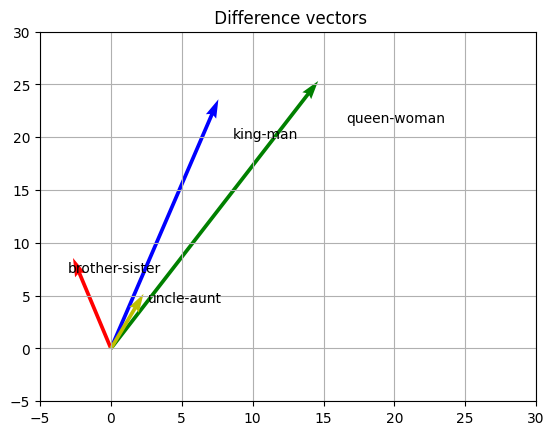

In [26]:
# Creating plot
plt.quiver(vector_1[0], vector_1[1], color='b', units='xy', scale=1)
plt.annotate('king-man', (vector_1[0], vector_1[1]))

plt.quiver(vector_2[0], vector_2[1], color='g', units='xy', scale=1)
plt.annotate('queen-woman', (vector_2[0], vector_2[1]))

plt.quiver(vector_3[0], vector_3[1], color='r', units='xy', scale=1)
plt.annotate('brother-sister', (vector_3[0], vector_3[1]))

plt.quiver(vector_4[0], vector_4[1], color='y', units='xy', scale=1)
plt.annotate('uncle-aunt', (vector_4[0], vector_4[1]))

plt.title(' Difference vectors')

# x-lim and y-lim
plt.xlim(-5,30)
plt.ylim(-5, 30)


# Show plot with grid
plt.grid()
plt.show()